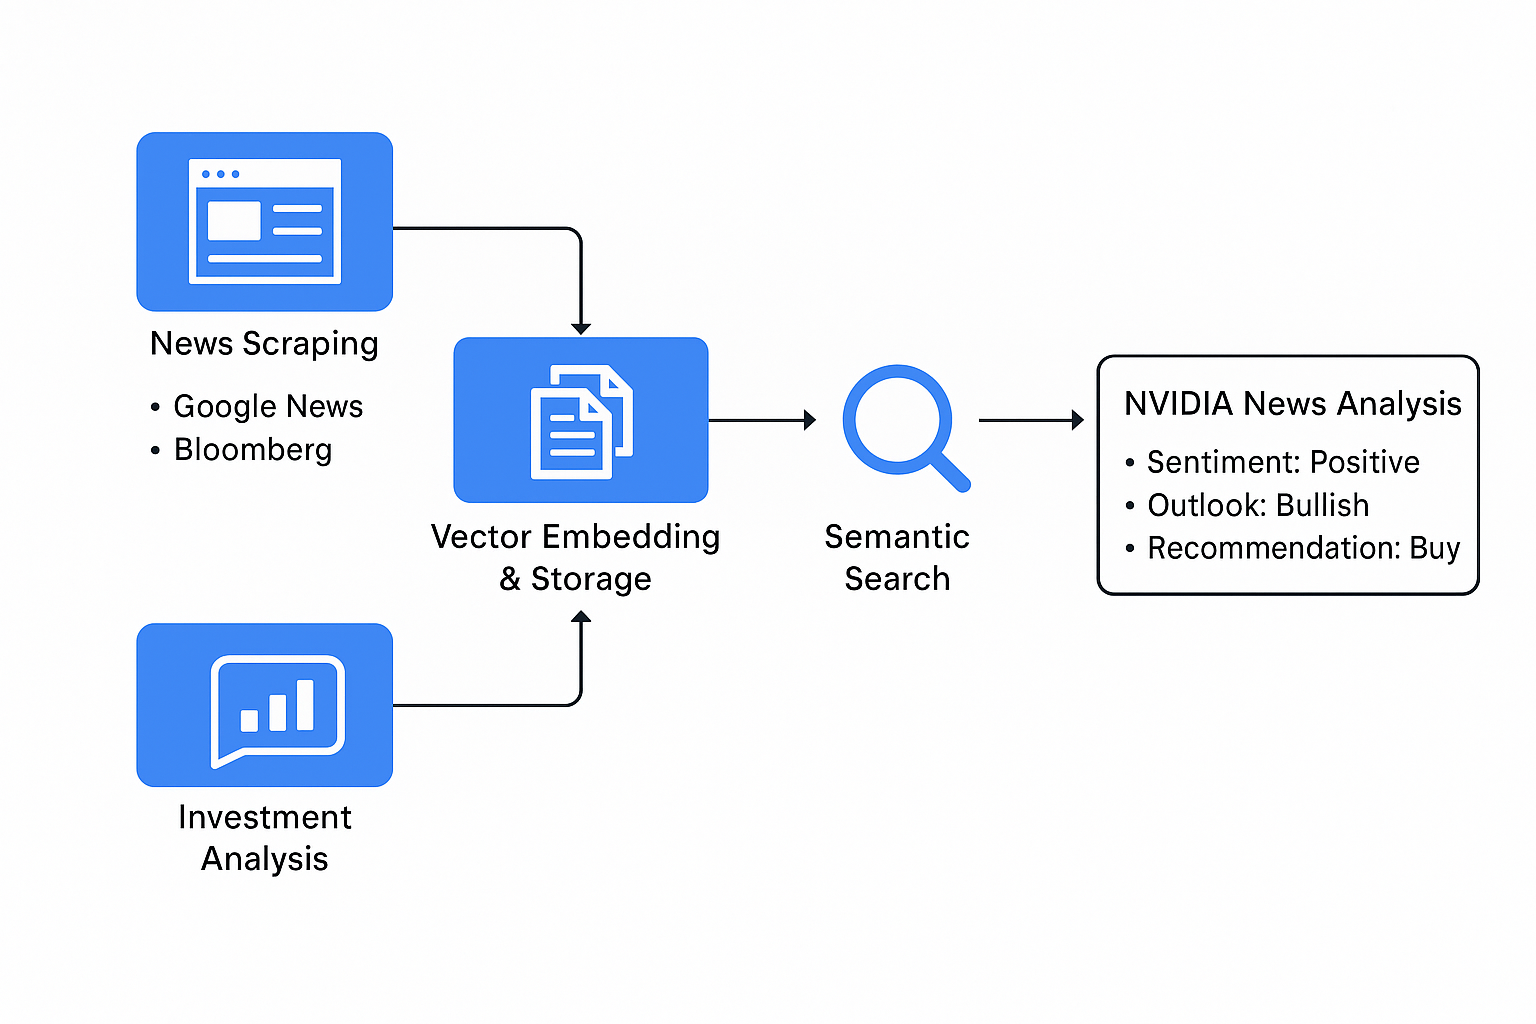

In [10]:
from IPython.display import Image
Image(filename='/kaggle/input/nvidia-news-project-workflow/Automated NVIDIA News Analysis Workflow.png')


This project builds an automated pipeline that gathers and analyses the latest news about **NVIDIA** to generate **investment insights** using Natural Language Processing (NLP) and Large Language Models (LLMs).

### 🔍 What It Does:

* 📰 **Scrapes and cleans** news articles from sources like Google News
* 🧠 **Embeds and stores** article titles in a vector database using `sentence-transformers`
* 🔎 **Performs semantic search** to find articles related to a given query (not just keyword matching)
* 💬 **Analyzes sentiment** and passes results to Google's **Gemini LLM** via LangChain
* 📊 **Generates investment-focused summaries**, including sentiment, outlook, and recommendations

### 🛠️ Technologies Used:

* `feedparser`, `BeautifulSoup`, `pandas` for data gathering
* `sentence-transformers`, `ChromaDB` for semantic search
* `HuggingFace Transformers` for sentiment analysis
* `LangChain` + `Google Gemini (gemini-1.5-flash)` for LLM-based analysis

---

> 🚀 **Goal**: Provide quick, actionable insights for investors based on real-time news data.


# 1. Installing Libraries

## 1.1 feedparser

Parses RSS and Atom feeds (used in news aggregators, blogs, podcasts).


In [1]:
%%capture
!pip install feedparser 

## 1.2 chromadb

A vector database for storing and searching embeddings (e.g., from sentence transformers or LLMs).

In [2]:
%%capture
!pip install chromadb 

## 1.3 sentence_transformers

Generates embeddings (vector representations) for sentences and documents.

In [3]:
%%capture 
!pip install sentence_transformers

## 1.4 langchain-community

A plugin for the main LangChain framework. It provides community-contributed tools, integrations (e.g., tools for web scraping, API calling, etc.).

In [4]:
%%capture 
!pip install  langchain-community

## 1.5 langchain, langchain-core, langchain-google-genai

These are part of the LangChain ecosystem for building intelligent agents and apps using LLMs like ChatGPT or Gemini.

🔸 langchain
Main package of LangChain, lets you build LLM applications with chains, tools, memory, agents, etc.

🔸 langchain-core
The foundational library. Other LangChain packages build on this. Provides base components.

🔸 langchain-google-genai
A connector to use Google’s Gemini/PaLM APIs inside LangChain chains and agents.

In [6]:
%%capture
!pip install -q --upgrade langchain-core langchain langchain-google-genai

# 2. Import Libraries

In [7]:
# Data and Time
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

# Web scraping and RSS
import feedparser
import requests
from bs4 import BeautifulSoup

# Text and NLP
import re
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')  # Make sure NLTK's tokenizer is ready

# Transformers and Embeddings
from transformers import pipeline
from langchain.embeddings import HuggingFaceEmbeddings

# Vector Storage
import chromadb
from langchain.vectorstores import Chroma

# Google Generative AI
import google.generativeai as genai
from langchain_google_genai import GoogleGenerativeAI

# LangChain for LLM workflows
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

# Clustering
from sklearn.cluster import KMeans
from collections import defaultdict

# Kaggle Secrets (if using in Kaggle)
from kaggle_secrets import UserSecretsClient


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 3. Automated News Analysis for Investment Insights Using NLP and LLMs

## 3.1 `NewsFetcher`


### 📦 `NewsFetcher` – Fetch & Clean News

* **`fetch_google_news()`**:
  Parses NVIDIA-related articles from Google News RSS using `feedparser`.

* **`clean_text(text)`**:
  Removes HTML tags and special characters using regex.

* **`fetch_all_news()`**:

  * Collects articles into a DataFrame.
  * Cleans titles and summaries.
  * Converts publish dates to `datetime`.

---

### 🧠 `NewsSemanticSearch` – Analyze & Search

* **`__init__()`**:
  Loads:

  * `HuggingFaceEmbeddings` for vector encoding.
  * `pipeline("sentiment-analysis")` for analyzing tone.

* **`create_vectorstore(df)`**:

  * Embeds cleaned news titles.
  * Stores vectors in `Chroma` with metadata (like sentiment & link).

* **`search_news(query, vectorstore)`**:
  Returns top-matching news articles using **semantic similarity search**.


In [35]:
class NewsFetcher:
    def __init__(self):
        self.sources = {
            'google': 'https://news.google.com/rss/search?q=NVIDIA',
            'reuters': 'https://www.reutersagency.com/feed/?best-topics=tech&post_type=best',
            'bloomberg': 'https://www.bloomberg.com/feeds/sitemap_news.xml'
        }
        
    def fetch_google_news(self):
        feed = feedparser.parse(self.sources['google'])
        articles = []
        
        for entry in feed.entries:
            articles.append({
                'title': entry.title,
                'link': entry.link,
                'published': entry.published if 'published' in entry else None,
                'summary': entry.summary if 'summary' in entry else None,
                'source': 'Google News'
            })
        return articles

    def clean_text(self, text):
        # Remove HTML tags
        text = re.sub(r'<[^>]+>', '', text)
        # Remove special characters
        text = re.sub(r'[^\w\s]', '', text)
        return text.strip()

    def fetch_all_news(self):
        all_articles = []
        all_articles.extend(self.fetch_google_news())
        
        # Convert to DataFrame
        df = pd.DataFrame(all_articles)
        
        # Clean the data
        df['title'] = df['title'].apply(self.clean_text)
        df['summary'] = df['summary'].apply(self.clean_text)
        
        # Convert published date to datetime
        df['published'] = pd.to_datetime(df['published'], errors='coerce')
        
        return df

class NewsSemanticSearch:
    def __init__(self):
        self.embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
        self.sentiment_analyzer = pipeline("sentiment-analysis")
        
    def analyze_sentiment(self, text):
        result = self.sentiment_analyzer(text)[0]
        return {
            'label': result['label'],
            'score': result['score']
        }
    
    def create_vectorstore(self, df):
        # Prepare metadata
        metadatas = []
        for _, row in df.iterrows():
            sentiment = self.analyze_sentiment(row['title'])
            metadatas.append({
                'published': str(row['published']),
                'link': row['link'],
                'source': row['source'],
                'sentiment': sentiment['label'],
                'sentiment_score': sentiment['score']
            })
        
        # Create ChromaDB vectorstore
        vectorstore = Chroma.from_texts(
            texts=df['title'].tolist(),
            embedding=self.embedding_function,
            metadatas=metadatas,
            collection_name="nvidia_news"
        )
        
        return vectorstore
    
    def search_news(self, query, vectorstore, filters=None, k=5):
        results = vectorstore.similarity_search(
            query=query,
            k=k,
            filter=filters
        )
        return results

## 3.2 `NewsAnalyzer`




### 🔐 `__init__()`

* Loads **Google API key** from Kaggle secrets.
* Initializes:

  * `gemini-1.5-flash` (Google Generative AI) via `google.generativeai`.
  * `GoogleGenerativeAI` LLM for use with **LangChain**.
  * HuggingFace **sentence embeddings**.
  * HuggingFace **sentiment analysis** pipeline.

---

### 🗞️ `interpret_news(news_items)`

* Uses **LangChain + Gemini** to analyze a list of news items.
* Prompt asks Gemini to generate:

  * Overall sentiment
  * Key stock-related factors
  * Short-term outlook
  * Investment recommendation (`Buy` / `Hold` / `Sell`)

---

### 🔍 `search_news(query, vectorstore, k=5)`

* Performs **semantic search** on embedded news using a `Chroma` vectorstore.
* Returns top `k` most relevant news articles.



In [36]:
class NewsAnalyzer:
    def __init__(self):
        # Initialize API keys from Kaggle secrets
        user_secrets = UserSecretsClient()
        self.GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")
        
        # Configure Gemini
        genai.configure(api_key=self.GOOGLE_API_KEY)
        self.model = genai.GenerativeModel('gemini-1.5-flash')
        
        # Initialize LangChain Gemini
        self.llm = GoogleGenerativeAI(
            model="gemini-1.5-flash",
            google_api_key=self.GOOGLE_API_KEY,
            temperature=0.7
        )
        
        # Initialize other components
        self.embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
        self.sentiment_analyzer = pipeline("sentiment-analysis")
        
    def interpret_news(self, news_items):
        """Use Gemini to interpret and summarize news items"""
        # Create a prompt template
        prompt_template = PromptTemplate(
            input_variables=["news_items"],
            template="""
            Based on these NVIDIA news items, provide a concise investment analysis:
            1. Overall sentiment (Positive/Negative/Neutral)
            2. Key factors affecting NVIDIA's stock
            3. Short-term outlook (1-3 months)
            4. Investment recommendation (Buy/Hold/Sell) with brief reasoning
            
            News items:
            {news_items}
            
            Please provide a clear, concise investment analysis focusing on actionable insights.
            """
        )
        
        # Create a chain
        chain = LLMChain(llm=self.llm, prompt=prompt_template)
        
        # Run the chain
        response = chain.run(news_items=news_items)
        return response
    
        
    def search_news(self, query, vectorstore, k=5):
        """Perform semantic search on the news"""
        try:
            results = vectorstore.similarity_search(
                query=query,
                k=k
            )
            return results
        except Exception as e:
            print(f"Error in search: {e}")
            return []


## 3.3 `main()` 

This function runs an end-to-end **NVIDIA news analysis pipeline**:

1. **Fetches news** articles using `NewsFetcher`.
2. **Embeds and stores** them in a Chroma **vector database**.
3. **Performs semantic search** on user-defined queries.
4. **Interprets results** using Gemini to generate an investment summary.

> ✅ Automates news collection → semantic search → LLM-based investment insight.



In [37]:
def main():
    # Initialize components
    fetcher = NewsFetcher()
    analyzer = NewsAnalyzer()
    
    # Fetch news
    print("Fetching news...")
    df = fetcher.fetch_all_news()
    print(f"Fetched {len(df)} articles")
    
    # Create vectorstore
    print("Creating vectorstore...")
    vectorstore = Chroma.from_texts(
        texts=df['title'].tolist(),
        embedding=analyzer.embedding_function,
        metadatas=[{
            'published': str(row['published']),
            'link': row['link'],
            'source': row['source']
        } for _, row in df.iterrows()],
        collection_name="nvidia_news"
    )
    
    # Perform semantic search
    queries = [
        "NVIDIA's latest AI developments",
    ]
    
    # Perform semantic search for each query
    print("\nPerforming semantic searches...")
    for query in queries:
        print(f"\n🔍 Query: {query}")
        results = analyzer.search_news(query, vectorstore)
        
        if results:
            print(f"Found {len(results)} results:")
            for i, doc in enumerate(results, 1):
                print(f"\nResult {i}:")
                print(f"Title: {doc.page_content}")
                print(f"Published: {doc.metadata['published']}")
                print(f"Source: {doc.metadata['source']}")
                print(f"Link: {doc.metadata['link']}")
                print("-" * 80)
        else:
            print("No results found for this query.")

    
    # Interpret search results
    print("\n\u2022 \033[1mInterpreting search results...\033[0m")
    news_items = "\n".join([f"- {doc.page_content}" for doc in results])
    interpretation = analyzer.interpret_news(news_items)
    print("\n📊 News Interpretation:")
    print(interpretation)
    
    

if __name__ == "__main__":
    main()

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


Fetching news...
Fetched 99 articles
Creating vectorstore...

Performing semantic searches...

🔍 Query: NVIDIA's latest AI developments
Found 5 results:

Result 1:
Title: NVIDIA NasdaqGSNVDA Unveils AI Innovations Across Europe in Collaboration with Industry Leaders  Yahoo
Published: 2025-06-11 17:26:13
Source: Google News
Link: https://news.google.com/rss/articles/CBMihwFBVV95cUxNZzR2M2t5c2oyYjBuLXR3d196VmMwcmF1VWE3OXktTG5lbHdMUFVSR1dyN0MxdHdHcUVSNlAzQVlMM2pvR0NESEV6TGVNcDlCMkdzZFRqOHdOM0JWb3JUMWRXUWJhSW5pTGhMQ3o1SjAzZkRDOV83UXlLb0o5bzBXZ091UV9VN2s?oc=5
--------------------------------------------------------------------------------

Result 2:
Title: NVIDIA NasdaqGSNVDA Unveils AI Innovations Across Europe in Collaboration with Industry Leaders  Yahoo
Published: 2025-06-11 17:26:13
Source: Google News
Link: https://news.google.com/rss/articles/CBMihwFBVV95cUxNZzR2M2t5c2oyYjBuLXR3d196VmMwcmF1VWE3OXktTG5lbHdMUFVSR1dyN0MxdHdHcUVSNlAzQVlMM2pvR0NESEV6TGVNcDlCMkdzZFRqOHdOM0JWb3JUMWRXUWJhSW5

## 4. Project Wrap-Up

This project demonstrates how combining real-time news scraping, semantic search, and advanced language models can deliver actionable insights from vast amounts of unstructured data.

By automating the process from data collection to investment interpretation, it highlights the potential of AI-powered tools to assist decision-making in fast-moving markets.

**Next Steps:**  
- Expand to multiple companies and sectors  
- Incorporate real-time streaming news updates  
- Add quantitative financial data for richer context  
- Improve interpretability and user interaction  
